In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [27]:
TRAIN_PATH = "/train/"
CHECKPOINT_PATH =  "/checkpoint/"
FOLDER_PATH = "/folder/"
LOGS_PATH = "/logs/"
RESULTS_PATH = "/results/"

In [3]:
import torch
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json
import pandas as pd
import os
from datasets import load_dataset
from datasets import Dataset, ClassLabel

import torch.nn.functional as F
from torch import nn
from transformers import AutoModel, BertModel

from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn.functional import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import TrainerCallback, EarlyStoppingCallback

In [5]:
df_train = pd.read_csv('balanced_train.csv')
dataset =  Dataset.from_pandas(df_train)
dataset = dataset.cast_column('category', ClassLabel(names=['normal', 'satire', 'click-bait']))
hf_dataset_splits = dataset.train_test_split(test_size=0.3)
train_dataset = hf_dataset_splits['train']
df_test = pd.read_csv('balanced_test.csv')
dataset =  Dataset.from_pandas(df_train)
test_dataset = dataset.cast_column('category', ClassLabel(names=['normal', 'satire', 'click-bait']))
validation_dataset =  hf_dataset_splits['test']

Casting the dataset:   0%|          | 0/9837 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9837 [00:00<?, ? examples/s]

In [6]:
model_name = "dumitrescustefan/bert-base-romanian-cased-v1"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.config

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/397k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/500M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dumitrescustefan/bert-base-romanian-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "dumitrescustefan/bert-base-romanian-cased-v1",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

In [7]:
def preprocess_dataset(dataset, tokenizer):
    def tokenize_and_merge_title_content(examples):
        texts = [f"{examples['title']} {examples['content']}"]
        tokenized = tokenizer.batch_encode_plus(
            texts,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_token_type_ids=False,
        )
        return {
            "input_ids": tokenized["input_ids"][0],
            "attention_mask": tokenized["attention_mask"][0],
            "labels": examples["category"]
        }

    dataset = dataset.map(tokenize_and_merge_title_content, batched=False)
    dataset.set_format(
        type='torch',
        columns=['input_ids', 'attention_mask', 'labels']
    )
    return dataset

In [8]:
print(train_dataset.shape)
tokenized_train_dataset = preprocess_dataset(train_dataset, tokenizer)
tokenized_validation_dataset = preprocess_dataset(validation_dataset, tokenizer)

(6885, 3)


Map:   0%|          | 0/6885 [00:00<?, ? examples/s]

Map:   0%|          | 0/2952 [00:00<?, ? examples/s]

In [9]:
class BestModelCheckpointCallback(TrainerCallback):
    def __init__(self, trainer, early_stopping_patience, output_dir):
        self.early_stopping_patience = early_stopping_patience
        self.best_val_acc = None
        self.patience_counter = 0
        self.output_dir = output_dir
        self.trainer = trainer

    def on_log(self, args, state, control, logs=None, **kwargs):
        val_acc = logs.get("eval_accuracy")
        if val_acc is None:
            return

        if self.best_val_acc is None or self.best_val_acc > val_acc:
            self.best_val_acc = val_acc
            self.patience_counter = 0
            self.save_best_model_checkpoint()
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                control.should_training_stop = True

    def save_best_model_checkpoint(self):
        if self.output_dir is not None:
            self.trainer.save_model(self.output_dir)

In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [14]:
training_args = TrainingArguments(
    output_dir=RESULTS_PATH,
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir=LOGS_PATH,
    learning_rate=2e-5,
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)
checkpoint_path = CHECKPOINT_PATH

best_model_checkpoint_callback = BestModelCheckpointCallback(early_stopping_patience = 2,
                                                             output_dir = checkpoint_path,
                                                             trainer = trainer)

trainer.add_callback(early_stopping_callback)
trainer.add_callback(best_model_checkpoint_callback)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.413900,0.382777,0.906504,0.906771,0.907104,0.906750
2,0.296300,0.384227,0.906504,0.906624,0.908464,0.906701


TrainOutput(global_step=3444, training_loss=0.36034557240626813, metrics={'train_runtime': 1686.5367, 'train_samples_per_second': 8.165, 'train_steps_per_second': 2.042, 'total_flos': 3623071762114560.0, 'train_loss': 0.36034557240626813, 'epoch': 2.0})

In [16]:
trainer_path = FOLDER_PATH + "trainer"
trainer.save_model(trainer_path)

In [17]:
trainer = BertForSequenceClassification.from_pretrained(trainer_path)

In [18]:
def evaluate_custom_classifier(model, dataset, device):
    model.eval()

    correct_predictions = 0
    dataloader = DataLoader(dataset, batch_size=4)
    progress_bar = tqdm(dataloader, desc="Evaluate")

    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()

    accuracy = correct_predictions / len(dataset)
    return accuracy

In [19]:
def train_custom_classifier(model, train_dataset, val_dataset, optimizer, device, num_epochs):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        epoch_loss = 0
        correct_predictions = 0

        train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        progress_bar = tqdm(train_dataloader, desc="Train")

        for batch in progress_bar:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()

        epoch_loss /= len(train_dataset)
        accuracy = correct_predictions / len(train_dataset)

        print(f"Train Loss: {epoch_loss:.5f}, Train Accuracy: {accuracy:.5f}")
        val_accuracy = evaluate_custom_classifier(model, val_dataset, device)
        print(f"Validation Accuracy: {val_accuracy:.5f}")


In [20]:
class CustomClassifier(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(CustomClassifier, self).__init__()
        self.base_model = pretrained_model
        self.dropout = nn.Dropout(0.2)
        self.dense = nn.Linear(self.base_model.config.hidden_size, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        x = hidden_state[:, 0, :]
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)
        x = self.classifier(x)
        return x

    def predict(self, input_ids, attention_mask):
        outputs = self.forward(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs, dim=1)
        return predictions

In [22]:
custom_classifier = CustomClassifier(trainer.base_model, 3)

optimizer = torch.optim.AdamW(custom_classifier.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_custom_classifier(custom_classifier, tokenized_train_dataset, tokenized_validation_dataset, optimizer, device, num_epochs=3)

Epoch 1/3


Train: 100%|██████████| 1722/1722 [12:04<00:00,  2.38it/s]


Train Loss: 0.06720, Train Accuracy: 0.89935


Evaluate: 100%|██████████| 738/738 [01:31<00:00,  8.04it/s]


Validation Accuracy: 0.89634
Epoch 2/3


Train: 100%|██████████| 1722/1722 [11:45<00:00,  2.44it/s]


Train Loss: 0.05131, Train Accuracy: 0.92346


Evaluate: 100%|██████████| 738/738 [01:30<00:00,  8.11it/s]


Validation Accuracy: 0.90041
Epoch 3/3


Train: 100%|██████████| 1722/1722 [11:44<00:00,  2.45it/s]


Train Loss: 0.03213, Train Accuracy: 0.95527


Evaluate: 100%|██████████| 738/738 [01:30<00:00,  8.12it/s]

Validation Accuracy: 0.86992


In [24]:
custom_classifier_path = FOLDER_PATH + "custom_classifier.pth"
torch.save(custom_classifier.state_dict(), custom_classifier_path)

In [ ]:
classifier_model = CustomClassifier(trainer.base_model, 3)
classifier_model.load_state_dict(torch.load(custom_classifier_path, map_location=torch.device('cpu')))
classifier_model.to(device)


<ipython-input-72-8327476aca64>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier_model.load_state_dict(torch.load(custom_classifier_path, map_location=torch.devic

CustomClassifier(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [25]:
tokenized_test_dataset = preprocess_dataset(test_dataset, tokenizer)
test_accuracy = evaluate_custom_classifier(custom_classifier, tokenized_test_dataset, device)

Map:   0%|          | 0/9837 [00:00<?, ? examples/s]

Evaluate: 100%|██████████| 2460/2460 [05:03<00:00,  8.10it/s]


In [26]:
def predict_labels(model, dataset, device):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=8)
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model.predict(input_ids=input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.cpu().numpy())

    return predictions

In [27]:
predictions = predict_labels(custom_classifier, tokenized_test_dataset, device)
true_labels = tokenized_test_dataset["category"]

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-Score: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      3279
           1       0.86      0.97      0.91      3279
           2       1.00      1.00      1.00      3279

    accuracy                           0.94      9837
   macro avg       0.94      0.94      0.94      9837
weighted avg       0.94      0.94      0.94      9837



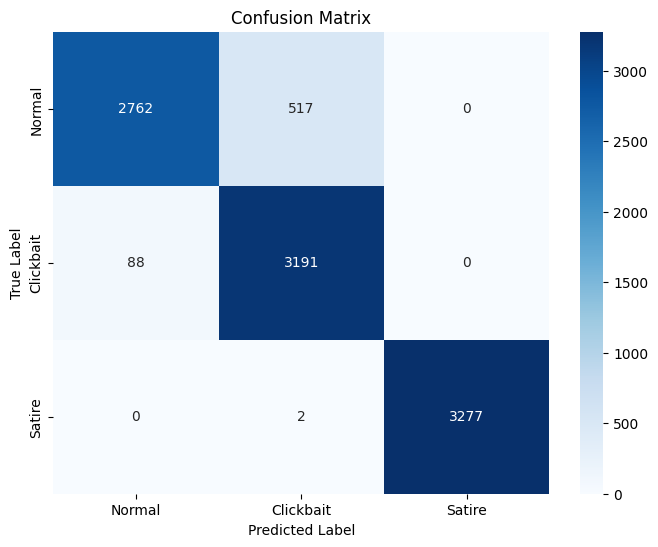

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

print("\nClassification Report:")
print(classification_report(true_labels, predictions))

cm = confusion_matrix(true_labels, predictions)
cm_df = pd.DataFrame(cm, index=['Normal', 'Clickbait', 'Satire'], columns=['Normal', 'Clickbait', 'Satire'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
model_name = "dumitrescustefan/bert-base-romanian-cased-v1"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, target):

        distances = 1.0 - cosine_similarity(output1, output2) # dissimilarity
        # distances: 0 - identical
        # distances: 1 - dissimilar

        # target == 1, just distance - to penalize the dissimilar pairs
        # target = 0, relu(margin - distance) - if the pair is dissimilar, but the distance is < margin, it contributes to the loss,
                                                # otherwise, the result is 0 so it doesnt contribute
        loss = 0.5 * (target.float() * distances +
                      (1.0 - target).float() * torch.relu(self.margin - distances).float())
        return loss.mean()

In [22]:
class SiameseNetworkWithLSTM(nn.Module):
    def __init__(self, lstm_hidden_size=128, num_classes=3):
        bert_model_name = "dumitrescustefan/bert-base-romanian-cased-v1"
        super(SiameseNetworkWithLSTM, self).__init__()
        self.text_encoder = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, batch_first=True)
        self.fc_lstm = nn.Linear(lstm_hidden_size, num_classes)

        self.fc_combined = nn.Linear(4, num_classes)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        output1 = self.text_encoder(input_ids=input_ids1, attention_mask=attention_mask1)
        embeddings1 = self.mean_pooling(output1.last_hidden_state, attention_mask1)

        output2 = self.text_encoder(input_ids=input_ids2, attention_mask=attention_mask2)
        embeddings2 = self.mean_pooling(output2.last_hidden_state, attention_mask2)

        similarity_score = 1.0 - cosine_similarity(embeddings1, embeddings2).unsqueeze(1)

        lstm_output, _ = self.lstm(output2.last_hidden_state)
        lstm_logits = self.fc_lstm(lstm_output[:, -1, :])
        combined_score = torch.cat((similarity_score, lstm_logits), dim=1)
        final_logits = self.fc_combined(combined_score)

        return similarity_score, lstm_logits, final_logits

    def mean_pooling(self, token_embeddings, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 5
batch_size = 4

model = SiameseNetworkWithLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [25]:
criterion_classification = nn.CrossEntropyLoss()  # Task-specific classification loss

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    progress_bar = tqdm(train_dataloader, desc="Train")
    correct_predictions = 0

    for batch in progress_bar:
        title, content, target = batch['title'], batch['content'], batch['category']  # target: 0, 1, 2

        inputs_title = tokenizer(title, padding=True, truncation=True, max_length=256, return_tensors='pt').to(device)
        inputs_content = tokenizer(content, padding=True, truncation=True, max_length=256, return_tensors='pt').to(device)

        optimizer.zero_grad()

        similarity_score, lstm_logits, final_logits = model(
            input_ids1=inputs_title['input_ids'],
            attention_mask1=inputs_title['attention_mask'],
            input_ids2=inputs_content['input_ids'],
            attention_mask2=inputs_content['attention_mask']
        )

        # Loss 2: Classification Loss
        loss = criterion_classification(final_logits, target.to(device))  # Use ground truth category

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(final_logits, dim=1).to(device)
        target = target.to(device)
        correct_predictions += (preds == target).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_dataloader)}")
    accuracy = correct_predictions / len(train_dataset)
    print(f"Train Accuracy: {accuracy:.5f}")



Train: 100%|██████████| 1722/1722 [07:26<00:00,  3.86it/s]


Epoch 1/5, Loss: 0.7699229902956682
Train Accuracy: 0.65258


Train: 100%|██████████| 1722/1722 [07:24<00:00,  3.88it/s]


Epoch 2/5, Loss: 0.5709214171656471
Train Accuracy: 0.72767


Train: 100%|██████████| 1722/1722 [07:24<00:00,  3.88it/s]


Epoch 3/5, Loss: 0.5235043642490791
Train Accuracy: 0.75701


Train: 100%|██████████| 1722/1722 [07:27<00:00,  3.85it/s]


Epoch 4/5, Loss: 0.49321168050187253
Train Accuracy: 0.76834


Train: 100%|██████████| 1722/1722 [07:29<00:00,  3.83it/s]

Epoch 5/5, Loss: 0.46759699434301577
Train Accuracy: 0.78591


In [28]:
siamese_classifier_path = FOLDER_PATH + "siamese_classifier.pth"
torch.save(model.state_dict(), siamese_classifier_path)

RuntimeError: Parent directory /folder does not exist.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizerFast

# Constants
BERT_MODEL = "dumitrescustefan/bert-base-romanian-cased-v1"
HIDDEN_SIZE = 768  # Size of BERT embeddings
LSTM_HIDDEN_SIZE = 256
NUM_CLASSES = 3  # Clickbait, Satire, Neutral

# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL)


class SiameseLSTMClassifier(nn.Module):
    def __init__(self):
        super(SiameseLSTMClassifier, self).__init__()
        # Single shared BERT encoder
        self.bert = BertModel.from_pretrained(BERT_MODEL)

        # LSTM for body embeddings
        self.lstm = nn.LSTM(HIDDEN_SIZE, LSTM_HIDDEN_SIZE, batch_first=True, bidirectional=True)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(LSTM_HIDDEN_SIZE * 2 + 1, 128),  # LSTM output + dissimilarity score
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, title_input_ids, title_attention_mask, body_input_ids, body_attention_mask):
        # Title encoding
        title_output = self.bert(input_ids=title_input_ids, attention_mask=title_attention_mask)
        title_embedding = title_output.last_hidden_state

        # Body encoding
        body_output = self.bert(input_ids=body_input_ids, attention_mask=body_attention_mask)
        body_embedding = body_output.lastpooler_output

        # Compute cosine dissimilarity
        cosine_similarity = F.cosine_similarity(title_embedding, body_embedding, dim=1)  # Shape: (batch_size,)
        dissimilarity_score = 1.0 - cosine_similarity
        dissimilarity_score = dissimilarity_score.unsqueeze(-1)  # Shape: (batch_size, 1)

        # LSTM on body embeddings
        body_hidden_states = body_output.last_hidden_state  # Sequence output
        lstm_output, _ = self.lstm(body_hidden_states)  # Get LSTM outputs
        lstm_embedding = torch.mean(lstm_output, dim=1)  # Mean-pooling over sequence

        # Concatenate dissimilarity score and LSTM embeddings
        fused_features = torch.cat([dissimilarity_score, lstm_embedding], dim=1)

        # Classification
        logits = self.classifier(fused_features)
        return logits


In [10]:
batch_size = 4

model = SiameseNetworkWithLSTM().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

NameError: name 'SiameseNetworkWithLSTM' is not defined

In [11]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 3

# Criterion for classification
model = SiameseLSTMClassifier().to(device)
criterion_classification = nn.CrossEntropyLoss()  # Loss for ternary classification
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    correct_predictions = 0

    for batch in progress_bar:
        # Extract inputs and target from the batch
        title, content, target = batch['title'], batch['content'], batch['category']  # target: 0, 1, 2

        # Tokenize title and body using the tokenizer
        inputs_title = tokenizer(title, padding=True, truncation=True, max_length=256, return_tensors='pt').to(device)
        inputs_content = tokenizer(content, padding=True, truncation=True, max_length=256, return_tensors='pt').to(device)

        optimizer.zero_grad()

        # Forward pass through the model
        final_logits = model(
            title_input_ids=inputs_title['input_ids'],
            title_attention_mask=inputs_title['attention_mask'],
            body_input_ids=inputs_content['input_ids'],
            body_attention_mask=inputs_content['attention_mask']
        )

        # Compute classification loss
        target = target.to(device)
        loss = criterion_classification(final_logits, target)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Update running loss and calculate accuracy
        running_loss += loss.item()
        preds = torch.argmax(final_logits, dim=1)
        correct_predictions += (preds == target).sum().item()

        # Update progress bar description
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))

    # Print epoch metrics
    epoch_loss = running_loss / len(train_dataloader)
    accuracy = correct_predictions / len(train_dataset)
    print(f"Epoch {epoch + 1} - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/3: 100%|██████████| 1722/1722 [07:49<00:00,  3.67it/s, loss=0.489]


Epoch 1 - Loss: 0.4893, Accuracy: 0.6725


Epoch 2/3: 100%|██████████| 1722/1722 [07:51<00:00,  3.65it/s, loss=1.02]


Epoch 2 - Loss: 1.0172, Accuracy: 0.3791


Epoch 3/3: 100%|██████████| 1722/1722 [07:51<00:00,  3.66it/s, loss=1.1]

Epoch 3 - Loss: 1.0988, Accuracy: 0.3335


In [ ]:
custom_data = [
    {"title": "Știre bombă: Descoperire majoră în domeniul AI", "content": "Cercetătorii anunță un nou model de inteligență artificială.", "expected": "real"},
    {"title": "10 metode rapide de a te îmbogăți!", "content": "Află cum să faci bani rapid și ușor.", "expected": "clickbait"},
    {"title": "Liderii mondiali declară că luna este făcută din brânză", "content": "O abordare satirică a evenimentelor recente.", "expected": "satire"},
]


In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


category_mapping = {"satire": 2, "clickbait": 1, "real": 0}
def evaluate_model(model, dataset, tokenizer, category_mapping, device):
    """
    Evaluate the model on a given dataset and print relevant metrics.

    Args:
    - model: The trained model to evaluate.
    - dataset: The dataset (train or validation) to evaluate on.
    - tokenizer: The tokenizer used for text preprocessing.
    - category_mapping: Mapping of category labels to class names.
    - device: The device to perform computation on (CUDA or CPU).
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    correct_predictions = 0
    total_predictions = 0

    # Iterate through the dataset
    for item in dataset:
        title, content, expected = item["title"], item["content"], item["category"]

        # Tokenize title and content
        inputs_title = tokenizer(title, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
        inputs_content = tokenizer(content, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)

        # Forward pass through the model
        with torch.no_grad():
            similarity_score, lstm_logits, final_logits = model(
                input_ids1=inputs_title['input_ids'],
                attention_mask1=inputs_title['attention_mask'],
                input_ids2=inputs_content['input_ids'],
                attention_mask2=inputs_content['attention_mask']
            )

            # Get predicted category
            pred_label = torch.argmax(final_logits, dim=1).item()
            # Store result for later evaluation
            predictions.append(pred_label)
            true_labels.append(expected)

            # Count correct predictions
            if pred_label == expected:
                correct_predictions += 1
            total_predictions += 1

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')


    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    print("\nClassification Report:")
    print(classification_report(true_labels, predictions))

    cm = confusion_matrix(true_labels, predictions)
    cm_df = pd.DataFrame(cm, index=['Normal', 'Clickbait', 'Satire'], columns=['Normal', 'Clickbait', 'Satire'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



In [37]:

# Usage Example for Train and Validation Datasets
# For training data
evaluate_model(model, train_dataset, tokenizer, category_mapping, device)


KeyboardInterrupt: 

In [ ]:

# For validation data
evaluate_model(model, validation_dataset, tokenizer, category_mapping, device)